## Delivery Duration Prediction

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration seconds , i.e., the time taken from:

__Start:__ the time consumer submits the order `(created_at)` to

__End:__ when the order will be delivered to the consumer `(actual_delivery_time)`

#### My Approach

The dataset comes with two other predicted values: `estimated_order_place_duration` and `estimated_store_to_consumer_driving_duration`. The missing piece is the amount of time the order spends in the store. In addition to generic feature engineering, I will be creating separate order 'prep_time' statistics tables/dataframes to simulate gold fact tables in a database or features from a feature store (i.e. Feather, Feast) that would in turn live in a data lake.

This is a fairly popular exercise so it is possible to derive performance objectives. My goal is to produce a feature set and model that has a test RMSE of less than 900 seconds against a holdout size of 0.2, a cross-validated RMSE of less than 950 and a test MAE of less than 600 seconds. My stretch goal is a cross-validated RMSE less than 900. For reference, the best models publically available produce a test RMSE around 980 - 1000 seconds with a holdout size of 0.2. 

In [2]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

import pandas as pd
import pyarrow as pa
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime as dt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,log_loss
from scipy import stats

from flaml import AutoML
from flaml.automl.model import XGBoostEstimator

In [3]:
np.random.seed(42)

In [40]:
## NOTE that all feature engineering functions can be found in doordash_feature_eng.py
train_df = pd.read_csv('train_df.csv')
train_df = train_df.drop(columns=['Unnamed: 0','latest_update'])

In [6]:
def createBaseline(historical_data:pd.DataFrame) -> pd.DataFrame:   #this function would be done in practice by SQL or Spark
    assert 'actual_total_delivery_duration' in historical_data.columns; 'Column actual_total_delivery_duration is not in the given DataFrame. Ensure that addFeatures_durations() was run on the provided DataFrame.'
    try:
        baseline_data = historical_data[['store_id','actual_total_delivery_duration']]
        baseline_data = baseline_data.dropna()
        baseline_data = pd.merge(
            left=baseline_data,
            right=baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean,np.std]),
            how='inner',
            on='store_id'
        )
        baseline_data['z-score'] = (baseline_data['actual_total_delivery_duration'] - baseline_data['mean']) / baseline_data['std']
        baseline_data = baseline_data.loc[(baseline_data['z-score'] <=3) & (baseline_data['z-score'] >= -3)]
        baseline_avgs = baseline_data.groupby('store_id').actual_total_delivery_duration.aggregate([np.mean])
        baseline_data = pd.merge(
            left=historical_data[['store_id','actual_total_delivery_duration']].dropna(),
            right=baseline_avgs,
            on='store_id'
        )
        baseline_MAE = mean_absolute_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'])
        baseline_RMSE = mean_squared_error(y_true=baseline_data['actual_total_delivery_duration'],y_pred=baseline_data['mean'],squared=False)
    except Exception as ex:
        raise ex
    return {'baseline_MAE:':baseline_MAE,'baseline_RMSE:':baseline_RMSE}

In [82]:
## Variance in average outstanding orders by hour between different markets. Different populations will generate a value less than 0.25 or greater than 4
# If the p-value for the Welch's t-test is less than 0.05, then the means of the populations are different enough to warrant splitting in feature development
print("Markets 1,2:")
print(np.var(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=False))
print("Markets 1,3:")
print(np.var(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 3].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=True))
print("Markets 1,4:")
print(np.var(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 4].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=False))
print("Markets 2,3:")
print(np.var(historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 3].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=False))
print("Markets 2,4:")
print(np.var(historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 4].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=True))
print("Markets 3,4:")
print(np.var(historical_data[historical_data['market_id'] == 3].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean))/np.var(historical_data[historical_data['market_id'] == 4].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean)))
print(stats.ttest_ind(historical_data[historical_data['market_id'] == 1].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),historical_data[historical_data['market_id'] == 2].groupby('created_hour_of_day').total_outstanding_orders.aggregate(np.mean),equal_var=False))

Markets 1,2:
0.14396329619338816
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.006338476911120953)
Markets 1,3:
2.6105510904958207
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.004771176546808944)
Markets 1,4:
0.13407092616734598
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.006338476911120953)
Markets 2,3:
18.133449007648636
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.006338476911120953)
Markets 2,4:
0.9312854714527126
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.004771176546808944)
Markets 3,4:
0.051357327062264826
Ttest_indResult(statistic=-3.020034348335915, pvalue=0.006338476911120953)


array([[<AxesSubplot:title={'center':'actual_total_delivery_duration'}>]],
      dtype=object)

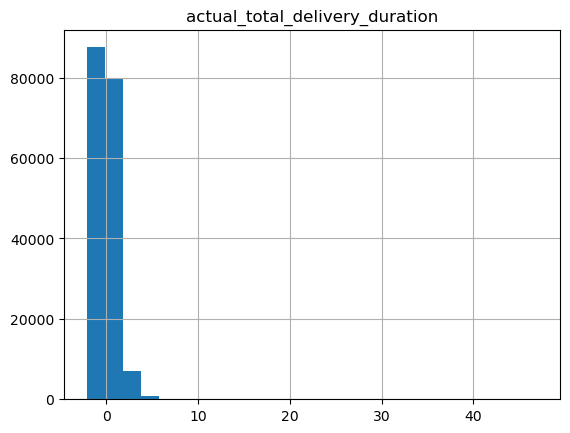

In [27]:
## What is the distribution of the actual_total_delivery_time values around the mean?
x = train_df[['actual_total_delivery_duration']].apply(stats.zscore)
x.hist(column='actual_total_delivery_duration',bins=25)

In [181]:
## dimensionality reduction functions with variance inflaction

def calcVIF(feature_frame:pd.DataFrame,target_feature:str):
    try:
        feature_frame = add_constant(feature_frame)
        feature_list = feature_frame.drop(columns=[target_feature]).columns.to_list()
        vif_frame = pd.DataFrame()
        vif_frame['feature'] = feature_list
        vif_frame['VIF'] = [variance_inflation_factor(feature_frame[feature_list].values,i) for i in range(len(feature_list))]
    except Exception as ex:
        raise ex
    return vif_frame.sort_values(by=['VIF'],ascending=False).reset_index(drop=True)

def VIF_dim_reduction(feature_frame:pd.DataFrame,target_feature:str,vif_limit:int):
    vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
    try:
        ## drop nan columns from feature set, nan VIF values from base VIF table
        vif_table['VIF'].replace(to_replace=[np.inf,-np.inf],value=np.nan,inplace=True)
        nan_list = vif_table[vif_table['VIF'].isnull()]['feature'].to_list()
        feature_frame = feature_frame.drop(columns=nan_list)
        vif_table = vif_table.set_index(vif_table.feature)
        vif_table = vif_table.drop(labels=nan_list).reset_index(drop=True)
        ## start
        multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
        while multicollinearity:
            lead_vif_feature = vif_table['feature'].values.tolist()[1]
            feature_frame = feature_frame.drop(columns=lead_vif_feature)
            vif_table = calcVIF(feature_frame=feature_frame,target_feature=target_feature)
            multicollinearity = True if vif_table['VIF'].values.tolist()[1] > vif_limit else False
    except Exception as ex:
        raise ex
    return feature_frame,vif_table

In [6]:
## feature selection/dimensionality reduction with PCA
##TODO #2 make a class for PCA
##TODO #3 retain row numbers in scaler --DONE

def build_train_test(dataset:pd.DataFrame,target_feature:str,test_size:int):
    try:
        X = dataset.drop(columns=target_feature)
        y = dataset[target_feature]
        x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=42)
        x_train,x_test = pd.DataFrame(x_train),pd.DataFrame(x_test)
    except Exception as ex:
        raise ex
    return x_train,x_test,y_train,y_test

def apply_standard_scaler(dataset):
#applies the standard scaler to a single dataset
    scaler = StandardScaler()
    try:
        if type(dataset) == pd.DataFrame:
            scaler = scaler.fit(dataset.values)
            dataset_scaled = scaler.transform(dataset.values)
            dataset_scaled = pd.DataFrame(dataset_scaled,index=dataset.index,columns=dataset.columns)
        else:
            scaler = scaler.fit(dataset)
            dataset_scaled = scaler.transform(dataset)
            test_stdScale = scaler.transform(dataset)
    except Exception as ex:
        raise ex
    return dataset_scaled,scaler

def transform_rmse_to_seconds(scaler,y_test,y_hat_scaled):
    try:
        y_hat_descaled = scaler.inverse_transform(y_hat_scaled.reshape(-1,1))
        rmse_descaled = mean_squared_error(y_pred=y_test,y_true=y_hat_descaled[:,0],squared=False)
    except Exception as ex:
        raise ex
    return y_hat_descaled,rmse_descaled

In [7]:
def PCAcalc_expl_var(x_train,target_expl_variance:int):
## returns the number of components required to explain the target_expl_variance
# and a feature to component ratio to support automation of further dimensionality reduction
    pca = PCA()
    x_train_scaled = apply_standard_scaler(x_train)[0]
    try:
        pca = pca.fit(x_train_scaled)
        components = np.cumsum(pca.explained_variance_ratio_)
        components = [i for i in components if i <= target_expl_variance]
        feature_to_component_ratio = len(components)/x_train.shape[1]
    except Exception as ex:
        raise ex
    return components,feature_to_component_ratio

def PCAcalc_dim_reduction(x_train,x_test,desired_components:int):
## you know, dimensionality reduction
    pca = PCA(n_components=desired_components)
    x_train_scaled,x_test_scaled = apply_standard_scaler(x_train)[0],apply_standard_scaler(x_test)[0]
    try:
        pca = pca.fit(x_train_scaled)
        x_train_pca,x_test_pca = pca.transform(x_train_scaled),pca.transform(x_test_scaled)
    except Exception as ex:
        raise ex
    return x_train_pca,x_test_pca

In [43]:
x_train,x_holdout,y_train,y_holdout = build_train_test(dataset=train_df,target_feature='actual_total_delivery_duration',test_size=0.2)

#### Dimensionality reduction with VIF

In [ ]:
VIF_features = VIF_dim_reduction(feature_frame=train_df,target_feature='actual_total_delivery_duration',vif_limit=20)[1]
VIF_featureset = VIF_features.drop(VIF_features[VIF_features.feature == 'const'].index)
VIF_featureset = VIF_featureset['feature'].to_list()
VIF_featureset = VIF_featureset + ['actual_total_delivery_duration']
VIF_train_df = train_df[VIF_featureset]

In [183]:
x_train_vif,x_test_vif = x_train[VIF_featureset],x_holdout[VIF_featureset]

We need 14 features (out of 24 available) to explain 90 percent of the variance after VIF dimensionality reduction


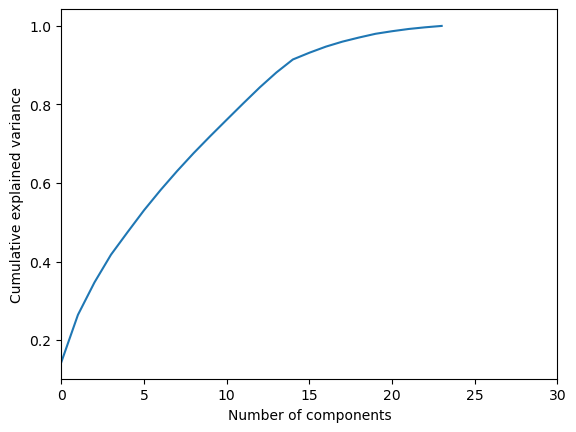

In [187]:
## how many features are needed to explain 90% of the variance?
print("We need " + str(len(PCAcalc_expl_var(x_train=x_train_vif,target_expl_variance=0.9)[0])) + " features (out of " + str(x_train_vif.shape[1]) + " available) to explain 90 percent of the variance after VIF dimensionality reduction")

vif_x_train_scaled = apply_standard_scaler(x_train_vif)[0]
pca = PCA().fit(vif_x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,30,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

#### Dimensionality reduction with PCA

In [20]:
x_train_pca,x_test_pca = PCAcalc_dim_reduction(x_train=x_train,x_test=x_holdout,desired_components=len(PCAcalc_expl_var(x_train=x_train,target_expl_variance=0.9)[0]))

### Model functions, model selection and first round results

In [14]:
## applicator function for ML methods

def applyMethod_make_regression(x_train,y_train,x_test,y_test,model):
    try:
        model.fit(x_train,y_train)
        ## train error
        y_hat_train = model.predict(x_train)
        train_RMSE = mean_squared_error(y_true=y_train,y_pred=y_hat_train,squared=False)
        train_MAE = mean_absolute_error(y_true=y_train,y_pred=y_hat_train)
        ## test error
        y_hat_test = model.predict(x_test)
        test_RMSE = mean_squared_error(y_true=y_test,y_pred=y_hat_test,squared=False)
        test_MAE = mean_absolute_error(y_true=y_test,y_pred=y_hat_test)
        eval_stats = {
            'train_RMSE:':train_RMSE,
            # gives context to the RMSE; the lower the ratio the better
            'train_RMSE_to_mean_ratio':train_RMSE / (np.mean(y_train)),
            'train_MAE:':train_MAE,
            'test_RMSE:':test_RMSE,
            # gives context to the RMSE; the lower the ratio the better
            'test_RMSE_to_mean_ratio':test_RMSE / (np.mean(y_test)),
            'test_MAE:':test_MAE
        }
        trained_model = model
    except Exception as ex:
        raise ex
    return trained_model,y_hat_test,eval_stats

In [77]:
def ApplyMethod_autoML_cv_ensemble(x_train,x_test,y_train,y_test,time_budget=int,metric=str,estimator_list=list,task=str,cv_folds=int):
    auto_ml = AutoML()
    kf = KFold(n_splits=cv_folds,random_state=42,shuffle=True)
    cv_scores = []
    cv_holdout_scores = []
    cv_models = []
## recall that the actual_total_delivery_time data is gamma distributed
    class xgbGamma(XGBoostEstimator):
        def __init__(self, task="regression", **config):
            super().__init__(objective='reg:gamma', **config)
    auto_ml.add_learner(learner_name="xgb_gamma",learner_class=xgbGamma)
    try:
        ## cross-validation
        for train_index,test_index in kf.split(x_train):
                cv_xtrain,cv_xtest = x_train.iloc[train_index],x_train.iloc[test_index]
                cv_ytrain,cv_ytest = y_train.iloc[train_index],y_train.iloc[test_index]
                auto_ml.fit(X_train=cv_xtrain,y_train=cv_ytrain,time_budget=time_budget,metric=metric,estimator_list=estimator_list,task=task,seed=42,verbose=0)
                ## store the model
                cv_models.append(auto_ml.model)
                cv_yhat = auto_ml.predict(cv_xtest)
                holdout_yhat = auto_ml.predict(x_test)
                if task == 'regression':
                    rmse = mean_squared_error(y_true=cv_ytest,y_pred=cv_yhat,squared=False)
                    cv_scores.append(rmse)
                    cv_holdout_scores.append(mean_squared_error(y_true=y_test,y_pred=holdout_yhat,squared=False))
                if task == 'classification':
                    accuracy = accuracy_score(y_true=cv_ytest,y_pred=cv_yhat)
                    cv_scores.append(accuracy)
                    cv_holdout_scores.append(accuracy_score(y_true=y_test,y_pred=cv_yhat))
    except Exception as ex:
        raise ex
    return cv_scores,cv_holdout_scores,cv_models

In [13]:
## TODO: #9 add cross-validation to final score delivery --DONE
def ApplyMethod_autoML(x_train,x_test,y_train,y_test,time_budget=int,metric=str,estimator_list=list,task=str,run_cv=bool,cv_folds=int):
    auto_ml = AutoML()
    kf = KFold(n_splits=cv_folds,random_state=42,shuffle=True)
    cv_scores = []
    cv_models = []
## recall that the actual_total_delivery_time data is gamma distributed
    class xgbGamma(XGBoostEstimator):
        def __init__(self, task="regression", **config):
            super().__init__(objective='reg:gamma', **config)
    auto_ml.add_learner(learner_name="xgb_gamma",learner_class=xgbGamma)
    try:
        auto_ml.fit(X_train=x_train,y_train=y_train,time_budget=time_budget,metric=metric,estimator_list=estimator_list,task=task,seed=42,verbose=0)
        trained_model = auto_ml
        feature_importances_df = pd.DataFrame({'features':auto_ml.feature_names_in_,'importance':auto_ml.feature_importances_})
        ## cross-validation
        if run_cv == True:
            model_count = 1
            for train_index,test_index in kf.split(x_train):
                cv_xtrain,cv_xtest = x_train.iloc[train_index],x_train.iloc[test_index]
                cv_ytrain,cv_ytest = y_train.iloc[train_index],y_train.iloc[test_index]
                auto_ml.fit(X_train=cv_xtrain,y_train=cv_ytrain,time_budget=time_budget,metric=metric,estimator_list=[str(trained_model.best_estimator)],task=task,seed=42,verbose=0)
                ## store the model
                cv_models.append(auto_ml.model)
                cv_yhat = auto_ml.predict(cv_xtest)
                if task == 'regression':
                    rmse = mean_squared_error(y_true=cv_ytest,y_pred=cv_yhat,squared=False)
                    cv_scores.append(rmse)
                if task == 'classification':
                    accuracy = accuracy_score(y_true=cv_ytest,y_pred=cv_yhat)
                    cv_scores.append(accuracy)
        if task == 'regression':
        ## test error
            y_hat_test = auto_ml.predict(x_test)
            test_RMSE = mean_squared_error(y_true=y_test,y_pred=y_hat_test,squared=False)
            test_MAE = mean_absolute_error(y_true=y_test,y_pred=y_hat_test)
            ## feature importances
            ## train error
            y_hat_train = auto_ml.predict(x_train)
            train_RMSE = mean_squared_error(y_true=y_train,y_pred=y_hat_train,squared=False)
            train_MAE = mean_absolute_error(y_true=y_train,y_pred=y_hat_train)
            eval_stats = {
                'train_RMSE:':train_RMSE,
                # gives context to the RMSE; the lower the ratio the better
                'train_RMSE_to_std_ratio':train_RMSE / (np.std(y_train)),
                'train_MAE:':train_MAE,
                'test_RMSE:':test_RMSE,
                # gives context to the RMSE; the lower the ratio the better
                'test_RMSE_to_std_ratio':test_RMSE / (np.std(y_test)),
                'test_MAE:':test_MAE
            }
        if task == 'classification':
            y_hat_test = auto_ml.predict(x_test)
            y_hat_test_proba = auto_ml.predict_proba(x_test)
            y_hat_train = auto_ml.predict(x_train)
            y_hat_train_proba = auto_ml.predict_proba(x_train)
            eval_stats = {
                'train_accuracy': accuracy_score(y_true=y_train,y_pred=y_hat_train),
                'train_roc_auc': roc_auc_score(y_true=y_train,y_score=y_hat_train_proba[:,1]),
                'test_accuracy': accuracy_score(y_true=y_test,y_pred=y_hat_test),
                'test_roc_auc': roc_auc_score(y_true=y_test,y_score=y_hat_test_proba[:,1])
            }
    except Exception as ex:
        raise ex
    return trained_model,feature_importances_df.sort_values(by='importance',ascending=False),eval_stats,cv_scores

#### PCA versus VIF dimensionality reduction:

TODO: #10 rewrite dimensionality reduction write-up

PCA:

    {'train_RMSE:': 931.81287,
    'train_RMSE_to_mean_ratio': 0.3266211655207943,
    'train_MAE:': 616.80505,
    'test_RMSE:': 922.12134,
    'test_RMSE_to_mean_ratio': 0.3238223636661371,
    'test_MAE:': 633.7323}

VIF:

    {'train_RMSE:': 844.9008,
    'train_RMSE_to_mean_ratio': 0.29615655663211077,
    'train_MAE:': 591.4,
    'test_RMSE:': 949.3395,
    'test_RMSE_to_mean_ratio': 0.33338058768003304,
    'test_MAE:': 649.18304}

No dimensionality reduction:

    {'train_RMSE:': 902.9004,
    'train_RMSE_to_mean_ratio': 0.31669177544879185,
    'train_MAE:': 590.48975,
    'test_RMSE:': 883.9196,
    'test_RMSE_to_mean_ratio': 0.30977442512176745,
    'test_MAE:': 603.2624}


Between the two dimensionality reduction options, PCA slightly beats out VIF. Given that the goal of dimensionality reduction is to reduce compute requirements (and therefore cost) while retaining as much of the unreduced model's performance as possible, it may be best to use a two-step approach. The first step would secure a list of the top ten or fifteen features from a model trained on the unreduced dataset during the regular retraining process and then run PCA on the remaining features. This lighter dataset would then be used to train a production model.

In [14]:
pca_regressions = ApplyMethod_autoML(
    x_train=x_train_pca,
    x_test=x_test_pca,
    y_train=y_train,
    y_test=y_holdout,
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5
    )
pca_regressions[2]


check Spark installation...This line should appear only once.

use_spark=True requires installation of PySpark. Please run pip install flaml[spark]
        and check [here](https://spark.apache.org/docs/latest/api/python/getting_started/install.html)
        for more details about installing Spark.


{'train_RMSE:': 962.5722570423924,
 'train_RMSE_to_std_ratio': 0.8285083410025038,
 'train_MAE:': 638.1465428280734,
 'test_RMSE:': 920.4128753844813,
 'test_RMSE_to_std_ratio': 0.8234671095960912,
 'test_MAE:': 640.1305807838371}

In [44]:
auto_xgb_no_reduction = ApplyMethod_autoML(
    x_train=x_train,
    x_test=x_holdout,
    y_train=y_train,
    y_test=y_holdout,
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    run_cv=False,
    cv_folds=5
)
auto_xgb_no_reduction[2]

{'train_RMSE:': 906.2222276609612,
 'train_RMSE_to_std_ratio': 0.7851626167178055,
 'train_MAE:': 598.708494124115,
 'test_RMSE:': 866.6903457569676,
 'test_RMSE_to_std_ratio': 0.7763823869026096,
 'test_MAE:': 596.007297493811}

In [138]:
print("Cross-validation results (RMSE): ")
print(auto_xgb_no_reduction[3])
print("Mean of cross-validation results (RMSE): " + str(np.mean(auto_xgb_no_reduction[3])))
print("Best estimator: " + auto_xgb_no_reduction[0].best_estimator)
print("Best configuration: ")
print(auto_xgb_no_reduction[0].best_config)

Cross-validation results (RMSE): 
[924.6696, 967.5788, 972.99457, 897.3391, 884.804]
Mean of cross-validation results (RMSE): 929.47723
Best estimator: xgb_limitdepth
Best configuration: 
{'n_estimators': 320, 'max_depth': 8, 'min_child_weight': 1.6246436031409632, 'learning_rate': 0.13924406975323256, 'subsample': 0.6897177882905062, 'colsample_bylevel': 0.9440262969164847, 'colsample_bytree': 1.0, 'reg_alpha': 0.005098546530512515, 'reg_lambda': 102.08934941463467}


In [45]:
auto_xgb_no_reduction[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
20,hour_mean_total_outstanding_orders,0.242148
10,est_time_non-prep,0.116266
16,onshift_to_outstanding,0.070525
31,hour_busy_outs_avg,0.051137
21,hour_mean_total_onshift_dashers,0.049111
53,store_day_median_total_prep_time,0.032786
35,market_day_mean_total_outstanding_orders,0.032590
49,store_day_of_week_est_time_prep_per_item_mean,0.022351
15,busy_to_outstanding,0.020434
12,orders_without_dashers,0.019857


In [78]:
auto_xgb_cv = ApplyMethod_autoML_cv_ensemble(
    x_train=x_train,
    x_test=x_holdout,
    y_train=y_train,
    y_test=y_holdout,
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    cv_folds=5
)
auto_xgb_cv[2]

In [91]:
print('Cross-validation results (RMSE): ')
print(auto_xgb_cv[0])
print('Mean of cross-validation results (RMSE): ')
print(np.mean(auto_xgb_cv[0]))

print('RMSE scores of cv models against holdout: ')
print(auto_xgb_cv[1])
print('Average RMSE score (ensemble score): ')
print(np.mean(auto_xgb_cv[1]))

Cross-validation results (RMSE): 
[764.5794060032332, 766.2712795989736, 757.600724721148, 792.9816669928537, 844.7342577630092]
Mean of cross-validation results (RMSE): 
785.2334670158436
RMSE scores of cv models against holdout: 
[842.1314633393378, 840.0196979261668, 840.8673760719671, 839.4876240369017, 840.9323899450047]
Average RMSE score (ensemble score): 
840.6877102638757


In [136]:
# does the first attempt at modeling improve on a baseline, average-derived model?
createBaseline(historical_data=train_df)

{'baseline_MAE:': 783.5442750429107, 'baseline_RMSE:': 19249.89784985233}

### Results so far

First and foremost, is the work and expense of building and maintaining a model worthwhile when compared to a simple 'baseline' approach that uses averages? The results for that baseline model are as follows:

    {'baseline_MAE:': 783.5442750429107, 'baseline_RMSE:': 19249.89784985233}

I scoured the internet and found two other worked examples that appear to use this dataset:

    Stratascratch: holdout RMSE: 986.6912510458277, holdout_size: 0.2,
    raihanmasud (github): mean 5-fold cv RMSE: 1030.6837, holdout RMSE: 1012, holdout_size: 0.33

Performance statistics for my xgboost model against a holdout sample size of 0.2 are as follows:

    {'train_RMSE:': 800.0005,
    'train_RMSE_to_std_ratio': 0.6904016675988109,
    'train_MAE:': 527.19244,
    'test_RMSE:': 876.9018,
    'test_RMSE_to_std_ratio': 0.7768734571659632,
    'test_MAE:': 597.0269}

    Cross-validation results (RMSE): 
    [924.6696, 967.5788, 972.99457, 897.3391, 884.804]

    Mean of cross-validation results (RMSE): 929.47723

Performance statistics for my xgboost model against a holdout size of 0.33:

    {'train_RMSE:': 873.4991,
    'train_RMSE_to_std_ratio': 0.7611590838185001,
    'train_MAE:': 581.7427,
    'test_RMSE:': 926.9857,
    'test_RMSE_to_std_ratio': 0.7968259664464706,
    'test_MAE:': 605.92535}

Conclusions:
1. The time, effort and expense of building and maintaining a model to predict total delivery time is validated by the comparative performance of the baseline approach.
2. There are two significant differences between my approach to this problem and the two other worked examples I found that I believe explain my superior performance. The first difference is the generic per-store order prep time features (addFeatures_store_prep_stats) and the market+hour aggregation features (addFeatures_relative_abundances). The author of the Stratascratch notebook attempted to predict order prep time and raihanmasud did not bother with prep time at all. Neither user bothered to generate aggregate values based on the most important features for their models. The second difference is my use of autoML to do hyperparameter tuning. Raihanmasud hard-coded hyperparameters for their model and the author of the official Stratascratch notebook did not bother with hyperparameter tuning at all.

Other observations:
1. Giving the model leaky features like the amount of time an order spent in the store (delivery_time - (est_order_creation_time + est_driving_duration)) as well as removing observations with high error produces a cross-validated RMSE scores between 250-350. The best holdout RMSE was around 240. From this one could infer that there is a performance floor.
2. Ratio features and store order preparation time features make up eleven of the top fifteen features and eight of the top ten features when ranked by importance. per the graph below there is also a visible increase in the delivery duration when the onshift-to-outstanding ratio decreases, either from high order volumes or low Dasher counts.
3. The table of category prep time metrics do not appear to have a significant effect on estimation, so those features can be left out of the final pipeline. 
4. Variance and independent population analysis confirmed that most of the markets have different hourly average order volumes, but the second-most important feature to the model so far is 'hour_mean_total_outstanding_orders', a basic average aggregation of order volumes across all markets.
5. Normalizing the dataset with a scaler does not produce a significantly better RMSE against the same holdout/test dataset (scaled RMSE 872.52985, unscaled RMSE 876.9018) despite taking longer to train a model.


<AxesSubplot:xlabel='onshift_to_outstanding', ylabel='actual_total_delivery_duration'>

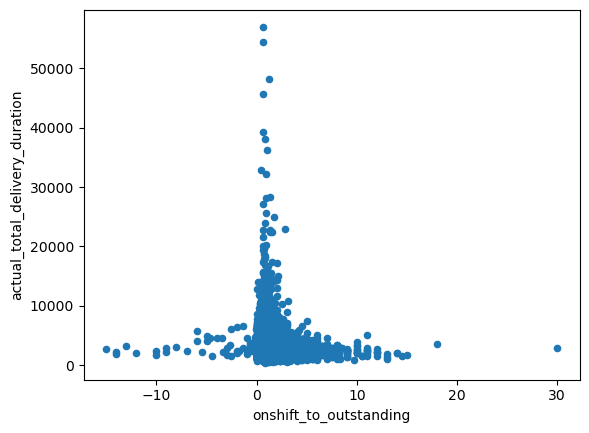

In [154]:
train_df.plot.scatter(x='onshift_to_outstanding',y='actual_total_delivery_duration')

#### What is the relationship between error and acutal_total_delivery_duration?

One could argue that scedasticity does not matter when we make predictions using gradient-boosted-trees - tree-based models are almost invariant to monotonic transformations - but transforms do affect split points. To that end, a test for scedasticity could improve our model if the conditional variance of the data is not constant.

Per the plots below, the variance of the error looks homoscedastic. Trying to actually run White's Lagrange test for heteroscedasticity needs more memory than I can give it.

AxesSubplot(0.125,0.11;0.775x0.77)


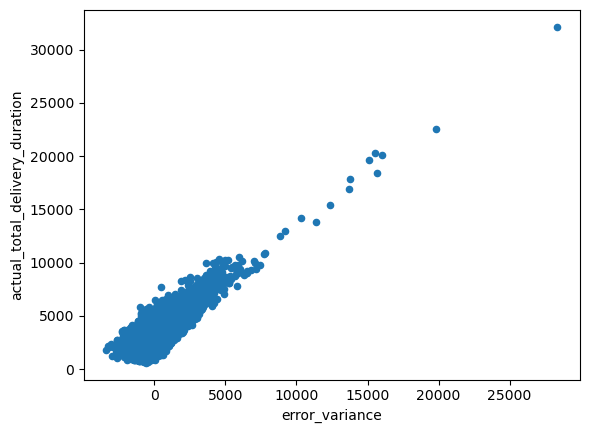

In [84]:
model = auto_xgb_no_reduction[0]
y_hat = model.predict(x_holdout)
error_train_df = x_holdout.copy()
error_train_df['yhat'] = y_hat.reshape(-1,1)
error_train_df = error_train_df.join(train_df[['actual_total_delivery_duration']])
error_train_df['error'] = error_train_df['actual_total_delivery_duration'] - error_train_df['yhat']
error_train_df['error_variance'] = error_train_df['error'] - error_train_df['error'].mean()
print(error_train_df.plot.scatter(x='error_variance',y='actual_total_delivery_duration'))
#error_train_df = error_train_df.drop(columns=['yhat','error','error_variance'])

In [ ]:
## DO NOT RUN THIS CELL unless you are very invested in knowing the scedasticity of the data. It is extremely compute and memory intensive.
# More to the point, scedasticity arguably does not matter for gradient-boosted trees
white_test = het_white(resid=error_train_df['error'].values,exog=x_holdout.values)
white_labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(white_labels,white_test)))

### What about a model that predicts order prep/in-store time?

1. Is the amount of time an order spends in the restaurant (prep time) an important feature? 
2. Would the accuracy of a total delivery time model be improved by having an estimation of order preparation time for each order?
3. Assuming the answers to the first two questions are true, is it worth keeping the store and category prepartion stats 'tables' I made during the feature engineering step?

In [59]:
def append_prep_feature(x_train,x_test,y_train,y_test):
## returns est_order_total_prep_time from a pre-existing train-test data set
    train,test = x_train.join(y_train),x_holdout.join(y_holdout)
    train['est_order_total_prep_time'] = train['actual_total_delivery_duration'] - train['est_time_non-prep']
    test['est_order_total_prep_time'] = test['actual_total_delivery_duration'] - test['est_time_non-prep']
    y_train_prep,y_holdout_prep = pd.Series(train['est_order_total_prep_time']),pd.Series(test['est_order_total_prep_time'])
    return y_train_prep,y_holdout_prep

In [178]:
## first and foremost, is this model worth building? Is in-store time an important feature?
train,test = x_train.join(y_train),x_holdout.join(y_holdout)
train['est_order_total_prep_time'] = train['actual_total_delivery_duration'] - train['est_time_non-prep']
test['est_order_total_prep_time'] = test['actual_total_delivery_duration'] - test['est_time_non-prep']

hypoth_feature_importances = ApplyMethod_autoML(
    x_train=train,
    x_test=test,
    y_train=y_train,
    y_test=y_holdout,
    time_budget=60,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost'],
    task='regression',
    run_cv=False,
    cv_folds=5
)
hypoth_feature_importances[2]

{'train_RMSE:': 312.8918,
 'train_RMSE_to_std_ratio': 0.270026123916784,
 'train_MAE:': 27.744295,
 'test_RMSE:': 251.92336,
 'test_RMSE_to_std_ratio': 0.2231864150144342,
 'test_MAE:': 26.811071}

In [179]:
hypoth_feature_importances[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
156,est_order_total_prep_time,0.348091
10,est_time_non-prep,0.209039
21,hour_mean_total_onshift_dashers,0.115692
16,onshift_to_outstanding,0.113821
9,estimated_store_to_consumer_driving_duration,0.084944
37,store_est_time_prep_per_item_median,0.031350
38,store_est_time_prep_per_item_mean,0.030787
39,store_est_time_prep_per_item_std,0.026761
36,store_est_time_prep_per_item_max,0.016004
8,estimated_order_place_duration,0.004808


Per the performance scores and feature importance table above, providing a delivery time estimation model with an order prep time estimation greatly improves the quality of estimations. Since the feature est_order_total_prep_time is leaky (it depends on the value we are trying to predict), we will need to estimate it instead.

In [60]:
y_train_prep,y_holdout_prep = append_prep_feature(x_train=x_train,x_test=x_holdout,y_train=y_train,y_test=y_holdout)

In [61]:
prep_est_model = ApplyMethod_autoML(
    x_train=x_train,
    x_test=x_holdout,
    y_train=y_train_prep,
    y_test=y_holdout_prep,
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    cv_folds=5,
    run_cv=False
)
prep_est_model[2]

{'train_RMSE:': 800.6859330186857,
 'train_RMSE_to_std_ratio': 0.715663472982321,
 'train_MAE:': 552.6452205371852,
 'test_RMSE:': 842.2164553161729,
 'test_RMSE_to_std_ratio': 0.7788351970887283,
 'test_MAE:': 564.320195743545}

In [ ]:
prep_est_cv_model = ApplyMethod_autoML_cv_ensemble(
    x_train=x_train,
    x_test=x_holdout,
    y_train=y_train_prep,
    y_test=y_holdout_prep,
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    cv_folds=5
)

In [90]:
print('RMSE scores of cv models against holdout: ')
print(prep_est_cv_model[1])
print('Average RMSE score (ensemble score): ')
print(np.mean(prep_est_cv_model[1]))

RMSE scores of cv models against holdout: 
[843.5441719919338, 839.5093461156963, 840.2338562223306, 838.207975286019, 840.5847270007723]
Average RMSE score (ensemble score): 
840.4160153233504


In [62]:
prep_est_model[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
16,onshift_to_outstanding,0.116629
53,store_day_median_total_prep_time,0.065109
15,busy_to_outstanding,0.048599
49,store_day_of_week_est_time_prep_per_item_mean,0.039615
20,hour_mean_total_outstanding_orders,0.028834
46,store_day_of_week_est_time_prep_per_item_min,0.023976
21,hour_mean_total_onshift_dashers,0.022726
54,store_day_mean_total_prep_time,0.022209
28,market_hour_busy_dasher_abd,0.021592
31,hour_busy_outs_avg,0.020918


In [63]:
yhat_train,yhat_test = prep_est_model[0].predict(x_train),prep_est_model[0].predict(x_holdout)
composite_train,composite_test = x_train,x_holdout
composite_train['pred_order_prep_time'],composite_test['pred_order_prep_time'] = yhat_train.reshape(-1,1),yhat_test.reshape(-1,1)
#composite_train['composite_deliv_time'],composite_test['composite_deliv_time'] = composite_train['pred_order_prep_time'] + composite_train['est_time_non-prep'],composite_test['pred_order_prep_time'] + composite_test['est_time_non-prep']
# composite_train,composite_test = composite_train.join(y_train),composite_test.join(y_holdout)

In [66]:
composite_deliv_model = ApplyMethod_autoML(
    x_train=composite_train.drop(columns=['actual_total_delivery_duration']),
    x_test=composite_test.drop(columns=['actual_total_delivery_duration']),
    y_train=y_train,
    y_test=y_holdout,
    time_budget=180,
    metric='mse',
    estimator_list=['xgb_gamma','xgboost','xgb_limitdepth'],
    task='regression',
    cv_folds=5,
    run_cv=False
)
composite_deliv_model[2]

{'train_RMSE:': 743.8711855802673,
 'train_RMSE_to_std_ratio': 0.6444995816078012,
 'train_MAE:': 525.3830954523438,
 'test_RMSE:': 839.3984891100266,
 'test_RMSE_to_std_ratio': 0.7519343047123673,
 'test_MAE:': 559.6701162579369}

w/ composite_deliv_time:
{'train_RMSE:': 815.1652,
 'train_RMSE_to_std_ratio': 0.7034888565661281,
 'train_MAE:': 570.45123,
 'test_RMSE:': 912.44415,
 'test_RMSE_to_std_ratio': 0.808361492679291,
 'test_MAE:': 600.00836}

cv RMSE scores: [867.7579, 910.20544, 906.0279, 855.9836, 840.6531]
Mean RMSE from cv: 876.1256
cv RMSE to y-true std: 0.7761858125345661

 w/o composite_deliv_time:
{'train_RMSE:': 793.01575,
 'train_RMSE_to_std_ratio': 0.6843738250531922,
 'train_MAE:': 559.7056,
 'test_RMSE:': 907.7776,
 'test_RMSE_to_std_ratio': 0.8042272435967454,
 'test_MAE:': 600.7541}

[860.98395, 901.5238, 898.82605, 853.83453, 833.52484]
869.73865
0.7705274115903241

In [196]:
print(composite_deliv_model[3])
print(np.mean(composite_deliv_model[3]))
print(np.mean(composite_deliv_model[3])/np.std(composite_test['actual_total_delivery_duration']))

[860.98395, 901.5238, 898.82605, 853.83453, 833.52484]
869.73865
0.7705274115903241


In [67]:
composite_deliv_model[1].sort_values(by='importance',ascending=False).head(15)

,features,importance
163,pred_order_prep_time,0.314096
10,est_time_non-prep,0.050941
9,estimated_store_to_consumer_driving_duration,0.022149
128,market_id__4.0,0.012894
16,onshift_to_outstanding,0.012503
76,clean_store_primary_category__dessert,0.011970
0,total_items,0.010003
21,hour_mean_total_onshift_dashers,0.009541
8,estimated_order_place_duration,0.009181
58,clean_store_primary_category__american,0.008342


Despite adding a new and promising feature, the inability of the first model to accurately estimate the amount of time an order spends in the store produces a somewhat disappointing outcome. The cross-validated RMSE is only 869.73865.